In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import PIL
from PIL import Image
import random
import os



In [3]:
random.seed(0)
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])


,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


Main Data Shape: (9896, 6)
Extra Data Shape: (10384, 4)
Common Columns: 
      InstanceID
      patientID
      ImageName
      isCancerous
Unique Main Columns: 
      cellType
      cellTypeName
Null Main Data: InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
Duplicated Main Data: 0
Images Duplicated:  0
Value counts for Iscancerous
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Percent size: 
0: 58.78132578819725
1: 41.21867421180275


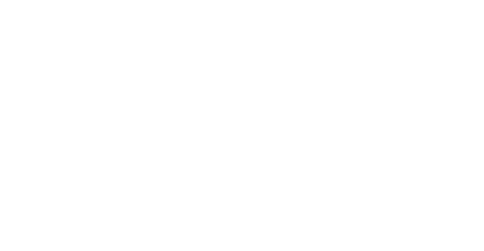

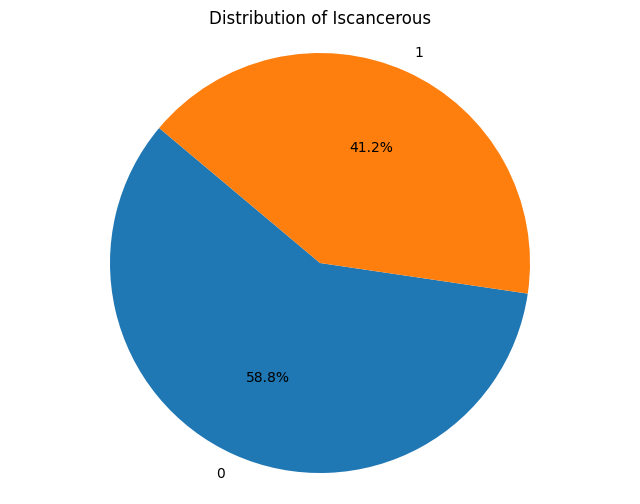

Value counts for Celltypename
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Percent size: 
Epithelial: 41.21867421180275
Inflammatory: 25.697251414713012
Fibroblast: 19.078415521422798
Others: 14.005658852061439


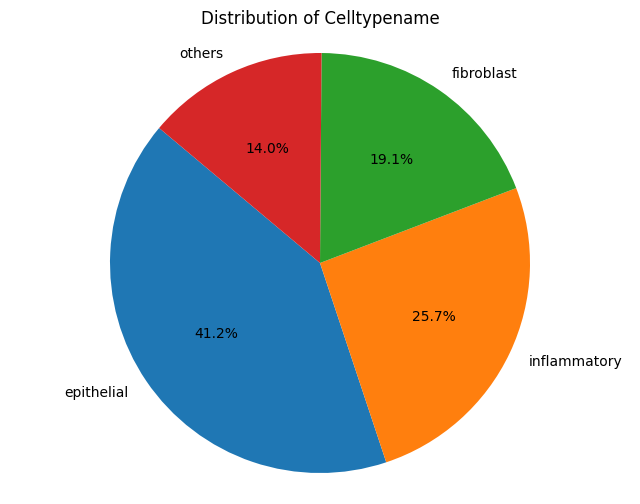

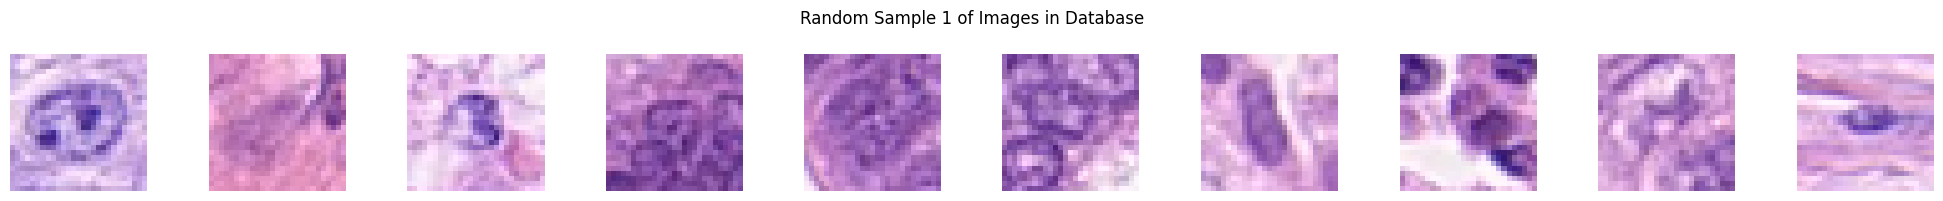

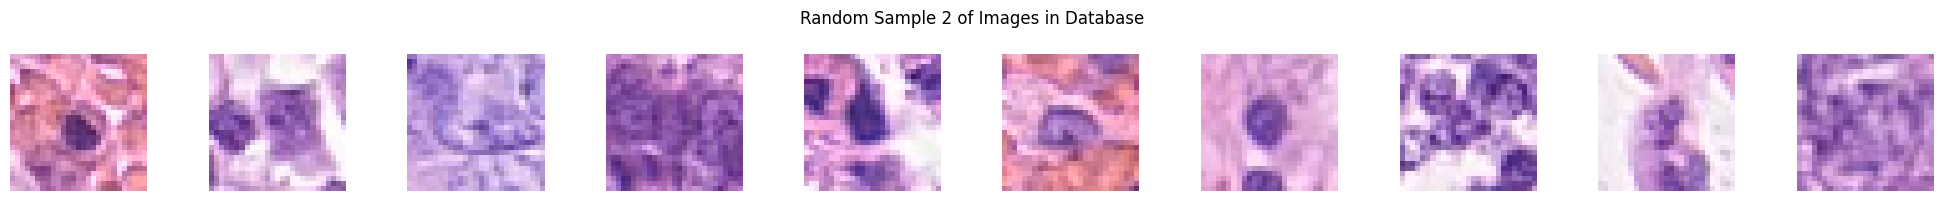

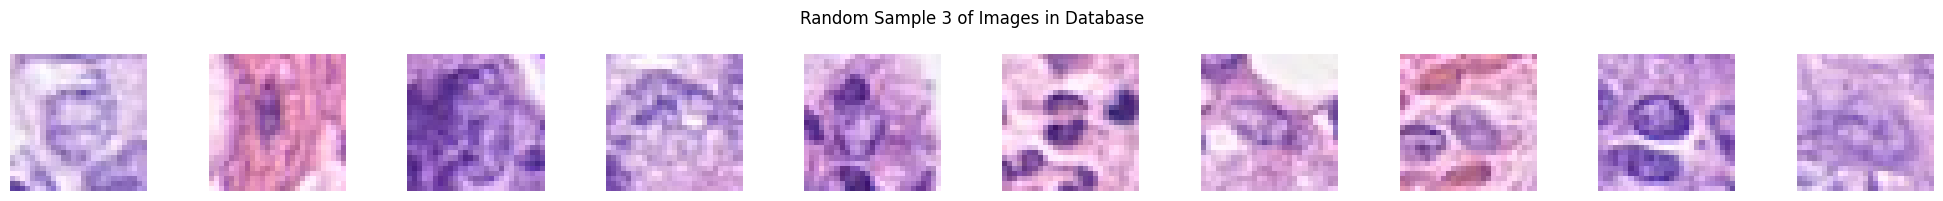

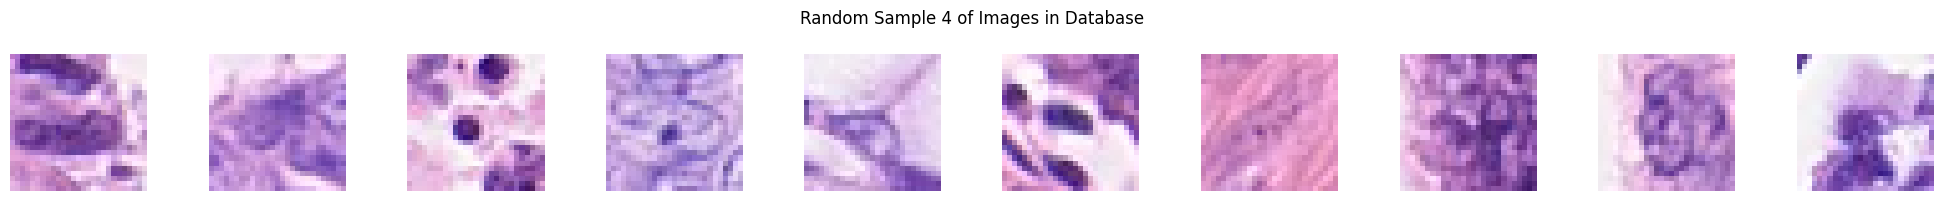

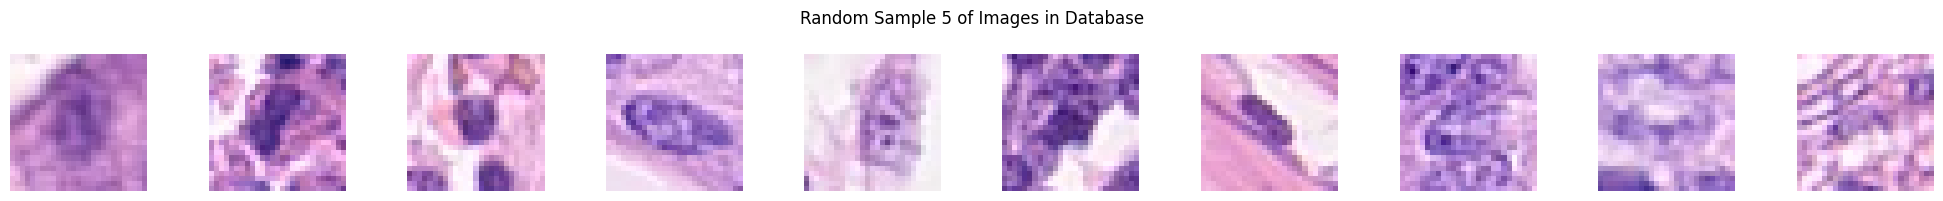

In [4]:
#EDA
fig, ax = plt.subplots(figsize=(6,3))
ax.axis("off")

#Structure and Size
print("Main Data Shape: " + str(data_main.shape))
print("Extra Data Shape: " + str(data_extra.shape))
print("Common Columns: ")

for column in data_main.columns.intersection(data_extra.columns):
    print("      "+ column)
print("Unique Main Columns: ")
for column in data_main.columns.symmetric_difference(data_extra.columns):
    print("      "+ column)

print("Null Main Data: " + str(data_main.isnull().sum()))
print("Duplicated Main Data: " + str(data_main.duplicated().sum()))
print("Images Duplicated:  " + str(data_main["ImageName"].duplicated().sum()))

#Value Counts
relevantColumns = ["isCancerous", "cellTypeName"]
for col in relevantColumns:
    print(f"Value counts for " + col.capitalize())
    value_counts = data_main[col].value_counts()
    print(value_counts)
    print("Percent size: " )
    
    for value, amount in data_main[col].value_counts().items():
        print(str(value).capitalize() + ": " + str((amount/len(data_main[col]))*100))
    
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.axis('equal')  
    plt.show()

pd.crosstab(data_main["cellTypeName"], data_main["isCancerous"])

#Random Sampling
dir = "./patch_images/" 
for i in range(1, 6):
    fig, axes = plt.subplots(1, 10, figsize=(20,2))
    fig.suptitle("Random Sample " + str(i) + " of Images in Database")
    sampledRows = data_main.sample(10)
    for j, ax in enumerate(axes):
        image_name = sampledRows.iloc[j]["ImageName"]
        img = np.asarray(Image.open(dir + image_name))
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [70]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

IMG_SIZE = 27
cell_type_counts = data_main["cellType"].value_counts().sort_index()
most_common_cell_type = cell_type_counts.idxmax()
print(most_common_cell_type)
max_value = cell_type_counts.max()
print(max_value)

cell_type_mapping = data_main.drop_duplicates(subset=["cellType"])[["cellType", "cellTypeName"]].sort_values("cellType")
cell_type_names = cell_type_mapping["cellTypeName"].values
cell_type_dict = dict(zip(cell_type_mapping["cellType"], cell_type_mapping["cellTypeName"]))
print(cell_type_dict)


cellType0Images = data_main[data_main["cellType"] == 0]["ImageName"].values
cellType1Images = data_main[data_main["cellType"] == 1]["ImageName"].values
cellType2Images = data_main[data_main["cellType"] == 2]["ImageName"].values
cellType3Images = data_main[data_main["cellType"] == 3]["ImageName"].values

imageCollections = []
imageCollections.append(cellType0Images)
imageCollections.append(cellType1Images)
imageCollections.append(cellType2Images)
imageCollections.append(cellType3Images)

data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
data_type_with_augmentation = data_type.copy()
cell_types_to_generate = cell_type_dict.copy()
del cell_types_to_generate[most_common_cell_type]
print(cell_types_to_generate)
dir = "./patch_images/"
for i, cellType in enumerate(cell_types_to_generate):
    cellTypeName = cell_type_dict[cellType]
    augDir = dir + "augmented_images/" + cellTypeName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    print(len(existing_aug) + len(imageCollections[i]))
    print(max_value)
    if not len(existing_aug) + len(imageCollections[i]) >= max_value:
        augmented_df = AugmentData(imageCollections[i], max_value, data_type, i, cell_type_dict[i])
        data_type_with_augmentation = pd.concat([data_type_with_augmentation, augmented_df], ignore_index=True)


2
4079
{0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}
{0: 'fibroblast', 1: 'inflammatory', 3: 'others'}
4079
4079
4079
4079
6772
4079


In [71]:

def AugmentData(imageNames ,maxCount, originalDF, label, labelName):
    
    counter = len(imageNames)

    augmentedRows = []
    
    dir = "./patch_images/"
    augDir = dir + "augmented_images/" + labelName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    existing_aug_count = len(existing_aug)
    counter += existing_aug_count
    print("Number of Files Detected: " + str(counter) + "Max Count: " + str(maxCount))
    if(counter >= maxCount):
        return

    # #Empty the directory
    # for fileName in os.listdir(augDir):
    #     file_path = os.path.join(augDir, fileName)
    #     if(os.path.isfile(file_path)):
    #         os.remove(file_path)

    
    while counter < maxCount:
        counter += 1
        #Pick and random image and open
        chosenImage = imageNames[random.randint(0, len(imageNames)-1)]
        openedImage = PIL.Image.open(dir + chosenImage).convert("RGB")
       
        #convert to data 
        image_np = np.array(openedImage)
        image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, 0)  # Add batch dimension
        
        data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        ])
        augmented_tensor = data_augmentation(image_tensor)
        augmented_image = tf.cast(tf.squeeze(augmented_tensor), tf.uint8).numpy()
        augmented_pil = PIL.Image.fromarray(augmented_image)

        augmentedImageName = "Augmented" + str(counter) +".png"
        save_path = os.path.join(augDir + augmentedImageName)
        augmented_pil.save(save_path)
        new_row = {"ImageName": augmentedImageName, "cellType": label, "cellTypeName": labelName}
        augmentedRows.append(new_row)
    
    return pd.DataFrame(augmentedRows)

In [72]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=5, verbose=1, mode='max', restore_best_weights=True)

**MLP**

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

In [75]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,642 (2.14 MB)

 Trainable params: 560,642 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [77]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [78]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [79]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - categorical_accuracy: 0.6851 - loss: 0.5929 - val_categorical_accuracy: 0.8267 - val_loss: 0.4864
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.7910 - loss: 0.4761 - val_categorical_accuracy: 0.8385 - val_loss: 0.4067
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8274 - loss: 0.4141 - val_categorical_accuracy: 0.8264 - val_loss: 0.4087
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8226 - loss: 0.3931 - val_categorical_accuracy: 0.8336 - val_loss: 0.3724
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8365 - loss: 0.3711 - val_categorical_accuracy: 0.8368 - val_loss: 0.3672
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8412 - loss: 0.3650 - val_categorical_accuracy: 0.7830 - val_loss: 0.4698
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8372 - loss: 0.3666 

Early stopping is triggered at epoch 10 with the best weights being found at epoch 7 meaning running it for longer either will make results worse or have no impact

In [80]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

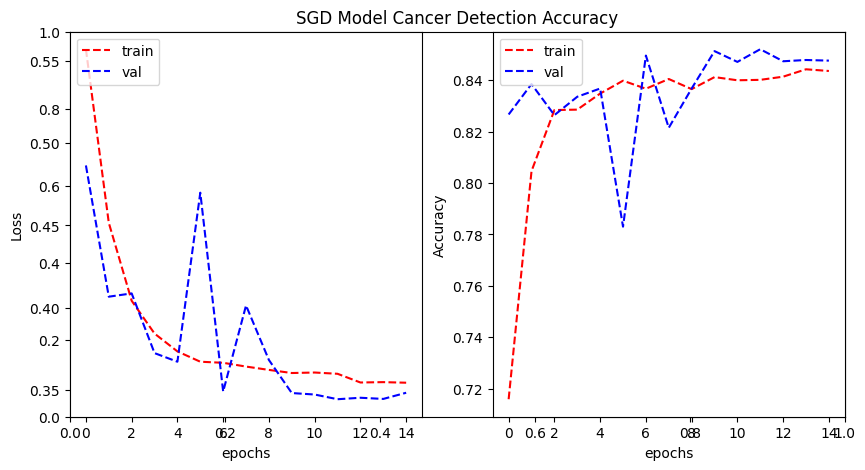

In [81]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [82]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


In [83]:
model.evaluate(test_generator)

 170/4056 ━━━━━━━━━━━━━━━━━━━━ 3s 888us/step - categorical_accuracy: 0.8278 - loss: 0.3840

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 874us/step - categorical_accuracy: 0.8465 - loss: 0.3564


[0.35005831718444824, 0.85108482837677]

**CNN**

In [84]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [86]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - categorical_accuracy: 0.6330 - loss: 0.6827 - val_categorical_accuracy: 0.6573 - val_loss: 0.6434
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6616 - loss: 0.6440 - val_categorical_accuracy: 0.6573 - val_loss: 0.6476
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - categorical_accuracy: 0.6555 - loss: 0.6485 - val_categorical_accuracy: 0.6573 - val_loss: 0.6432
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.6569 - loss: 0.6483 - val_categorical_accuracy: 0.6573 - val_loss: 0.6475
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6489 - loss: 0.6511 - val_categorical_accuracy: 0.6573 - val_loss: 0.6453
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6537 - loss: 0.6481 - val_categorical_accuracy: 0.6573 - val_loss: 0.6435
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

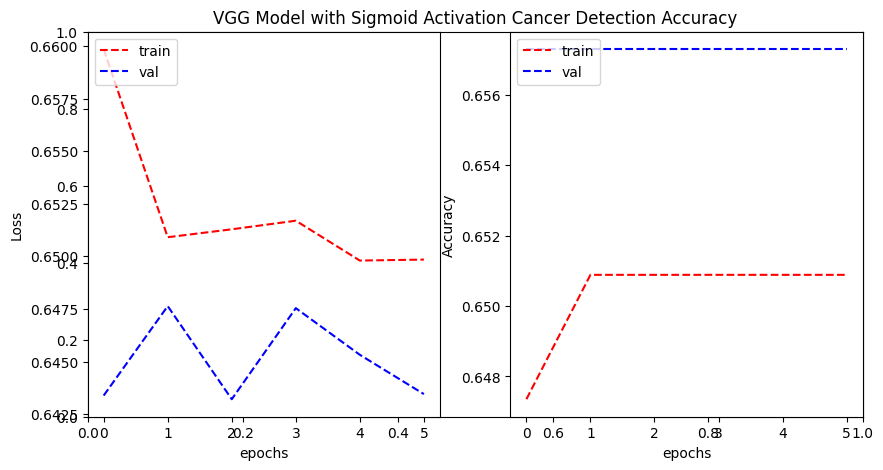

In [87]:
plot_learning_curve("VGG Model with Sigmoid Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [88]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.6485 - loss: 0.6485


[0.6492437720298767, 0.6471893787384033]

After doing some research, using sigmoid for the hidden layers can lead to learning stopping really early which is exactly what this looks like

In [89]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [90]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [91]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - categorical_accuracy: 0.7082 - loss: 0.5692 - val_categorical_accuracy: 0.8538 - val_loss: 0.3448
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8422 - loss: 0.3707 - val_categorical_accuracy: 0.8708 - val_loss: 0.3231
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8602 - loss: 0.3262 - val_categorical_accuracy: 0.8720 - val_loss: 0.2976
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8771 - loss: 0.3005 - val_categorical_accuracy: 0.8780 - val_loss: 0.2863
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8767 - loss: 0.2930 - val_categorical_accuracy: 0.8881 - val_loss: 0.2772
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8898 - loss: 0.2764 - val_categorical_accuracy: 0.8617 - val_loss: 0.3196
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.880

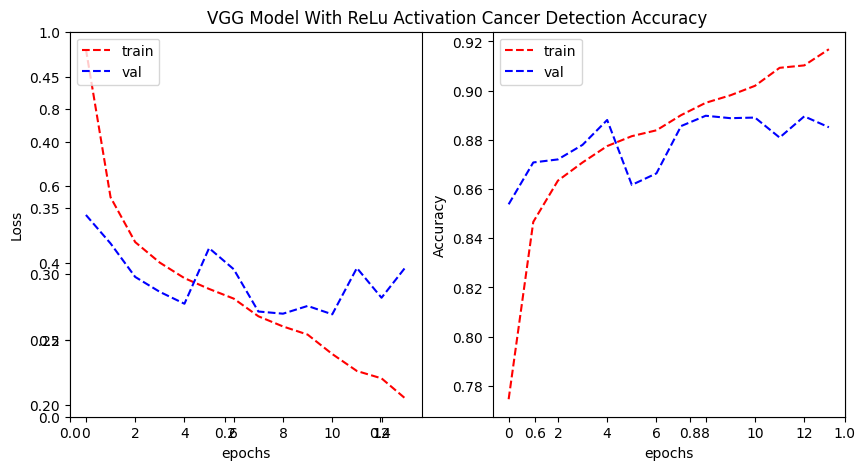

In [92]:
plot_learning_curve("VGG Model With ReLu Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [93]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - categorical_accuracy: 0.8907 - loss: 0.2524


[0.25670331716537476, 0.8922584056854248]

Now it is clearly overfitting so we can start by simplifying the model as the images are relatively simple

In [94]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [95]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [96]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7267 - loss: 0.5383 - val_categorical_accuracy: 0.8447 - val_loss: 0.3525
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8558 - loss: 0.3361 - val_categorical_accuracy: 0.8858 - val_loss: 0.2819
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8727 - loss: 0.3080 - val_categorical_accuracy: 0.8691 - val_loss: 0.3178
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8710 - loss: 0.2963 - val_categorical_accuracy: 0.8895 - val_loss: 0.2823
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8815 - loss: 0.2854 - val_categorical_accuracy: 0.8863 - val_loss: 0.2821
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8917 - loss: 0.2605 - val_categorical_accuracy: 0.8905 - val_loss: 0.2645
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.894

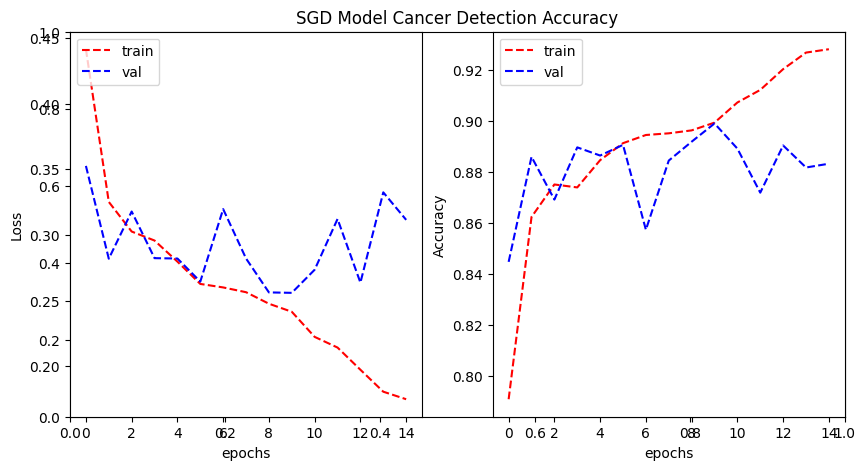

In [97]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [98]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.8972 - loss: 0.2538


[0.249080628156662, 0.9001479148864746]

The model is still overfitting but less so, now we can try regularisation

In [99]:
from tensorflow.keras import regularizers
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [100]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [101]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7513 - loss: 0.5965 - val_categorical_accuracy: 0.8131 - val_loss: 0.4700
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8438 - loss: 0.4104 - val_categorical_accuracy: 0.8501 - val_loss: 0.3844
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8534 - loss: 0.3848 - val_categorical_accuracy: 0.8674 - val_loss: 0.3525
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8675 - loss: 0.3551 - val_categorical_accuracy: 0.8748 - val_loss: 0.3352
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8674 - loss: 0.3537 - val_categorical_accuracy: 0.8770 - val_loss: 0.3477
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - categorical_accuracy: 0.8793 - loss: 0.3395 - val_categorical_accuracy: 0.8360 - val_loss: 0.4101
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - categorical_accuracy: 0.869

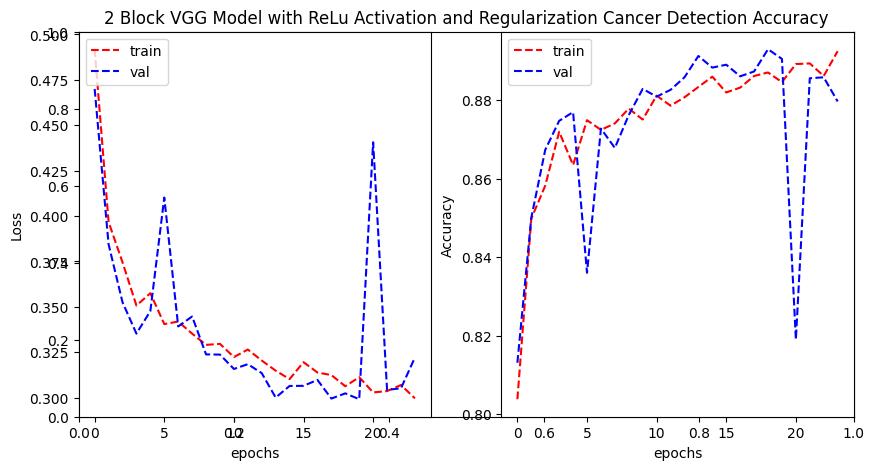

In [102]:
plot_learning_curve("2 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [103]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.8922 - loss: 0.2925


[0.29099905490875244, 0.8912721872329712]

This very clearly has worked so now we can try to add back the other hidden block and see if the model can handle it now or if it still is too complex for the task

In [104]:

model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [105]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [106]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - categorical_accuracy: 0.7469 - loss: 0.6902 - val_categorical_accuracy: 0.8548 - val_loss: 0.4025
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8501 - loss: 0.4146 - val_categorical_accuracy: 0.8454 - val_loss: 0.4194
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8606 - loss: 0.3765 - val_categorical_accuracy: 0.8735 - val_loss: 0.3425
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8638 - loss: 0.3640 - val_categorical_accuracy: 0.8711 - val_loss: 0.3455
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8663 - loss: 0.3616 - val_categorical_accuracy: 0.8481 - val_loss: 0.3887
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8667 - loss: 0.3469 - val_categorical_accuracy: 0.8851 - val_loss: 0.3201
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.874

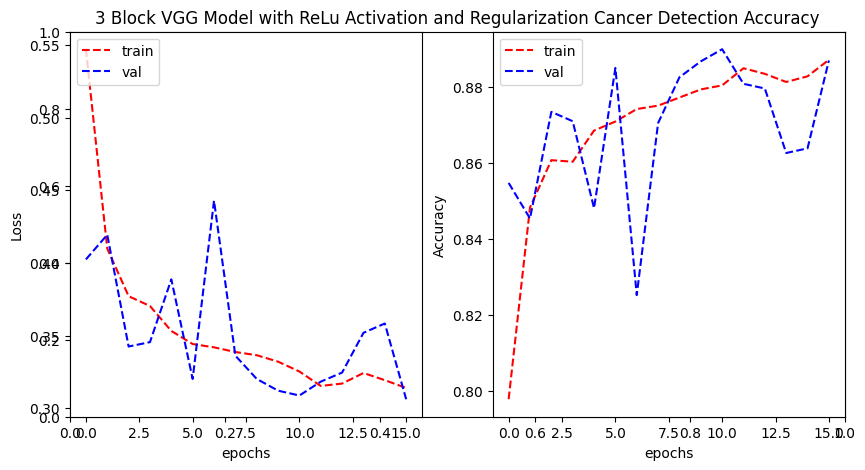

In [107]:
plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [108]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.8835 - loss: 0.3066


[0.2971968948841095, 0.891765296459198]

In [109]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
print(data_type)

      InstanceID  patientID  ImageName  cellType
0          22405          1  22405.png         0
1          22406          1  22406.png         0
2          22407          1  22407.png         0
3          22408          1  22408.png         0
4          22409          1  22409.png         0
...          ...        ...        ...       ...
9891        1625         60   1625.png         2
9892        1626         60   1626.png         2
9893        1627         60   1627.png         2
9894        1628         60   1628.png         2
9895        1629         60   1629.png         2

[9896 rows x 4 columns]


In [110]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [111]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [112]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
model_VGG_1_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [114]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_softmax = model_VGG_1_softmax.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - categorical_accuracy: 0.4981 - loss: 1.1712 - val_categorical_accuracy: 0.6948 - val_loss: 0.7917
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6851 - loss: 0.8041 - val_categorical_accuracy: 0.6594 - val_loss: 0.8371
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7247 - loss: 0.7135 - val_categorical_accuracy: 0.7054 - val_loss: 0.7274
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7338 - loss: 0.6914 - val_categorical_accuracy: 0.7448 - val_loss: 0.6743
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7457 - loss: 0.6528 - val_categorical_accuracy: 0.7337 - val_loss: 0.6745
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7527 - loss: 0.6445 - val_categorical_accuracy: 0.7585 - val_loss: 0.6247
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7657 - loss: 0

In [115]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


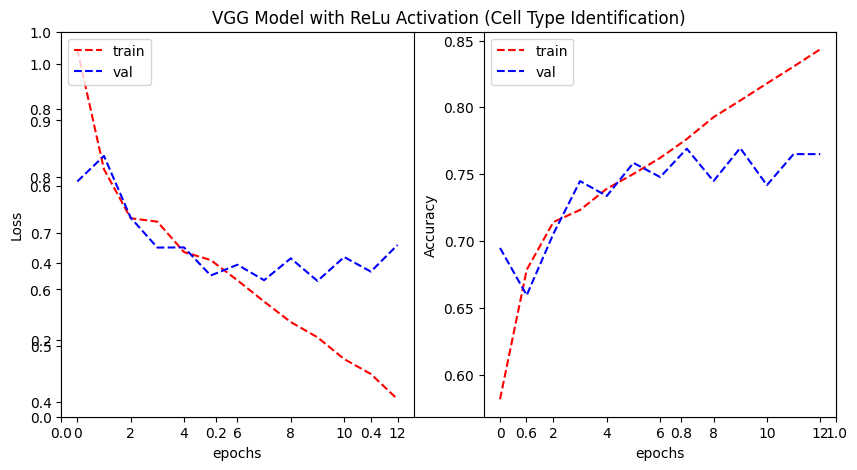

 105/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.8136 - loss: 0.5521

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.7468 - loss: 0.6544


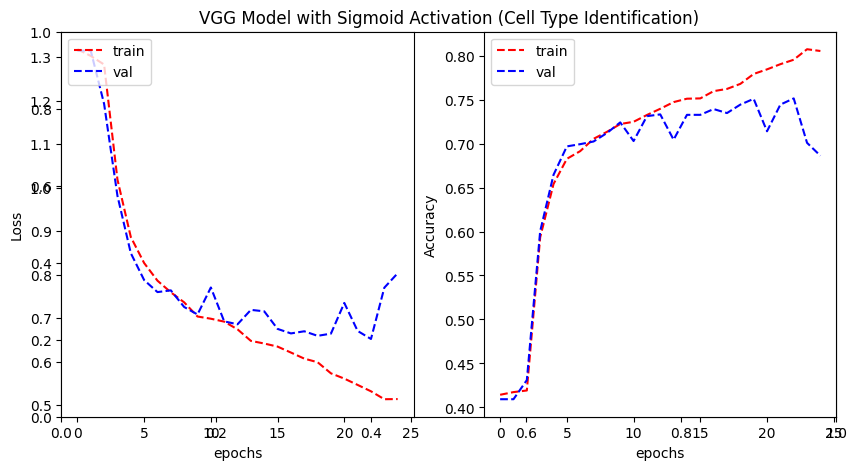

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.7267 - loss: 0.7087


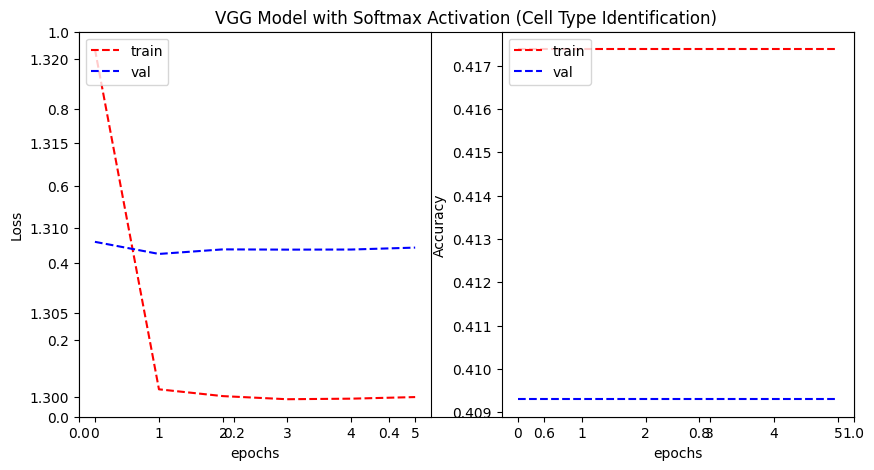

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.3886 - loss: 1.3252


[1.320934772491455, 0.3994949460029602]

In [116]:
plot_learning_curve("VGG Model with ReLu Activation (Cell Type Identification)",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)
plot_learning_curve("VGG Model with Sigmoid Activation (Cell Type Identification)",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)

plot_learning_curve("VGG Model with Softmax Activation (Cell Type Identification)",history_VGG_1_softmax.history['loss'], history_VGG_1_softmax.history['val_loss'], 
                    history_VGG_1_softmax.history['categorical_accuracy'], history_VGG_1_softmax.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax.evaluate(test_generator)


This shows a significant amount of overfitting, due to the model learning valuing irrelevant features like noise resulting in worse performance with new data

In [117]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    # preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.2),
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - categorical_accuracy: 0.4680 - loss: 1.3264 - val_categorical_accuracy: 0.6645 - val_loss: 0.9371
Epoch 2/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6667 - loss: 0.9278 - val_categorical_accuracy: 0.6882 - val_loss: 0.8256
Epoch 3/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6852 - loss: 0.8647 - val_categorical_accuracy: 0.6882 - val_loss: 0.8130
Epoch 4/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7007 - loss: 0.7952 - val_categorical_accuracy: 0.7256 - val_loss: 0.7442
Epoch 5/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7343 - loss: 0.7361 - val_categorical_accuracy: 0.7514 - val_loss: 0.7135
Epoch 6/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7408 - loss: 0.7336 - val_categorical_accuracy: 0.7292 - val_loss: 0.7369
Epoch 7/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.747

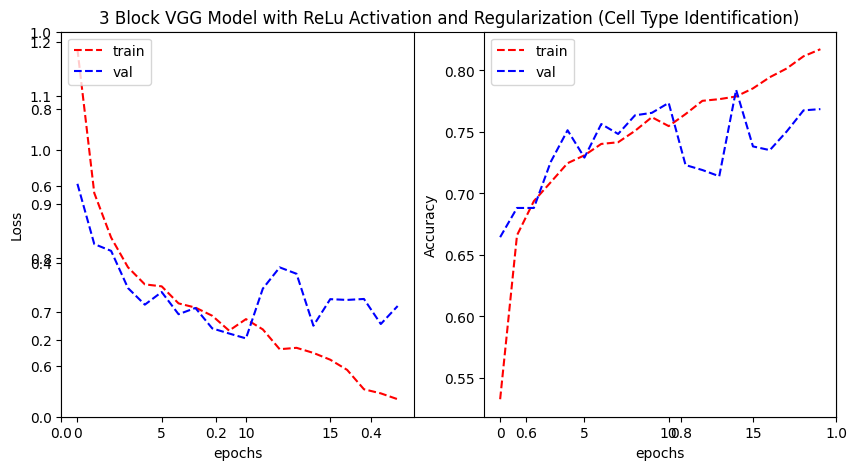

In [118]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=25, callbacks=earlyStop, verbose=1)

plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization (Cell Type Identification)", history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Significantly better results just with regularization, will try to fit better later

In [5]:
#Using extra data to  improve the cell type classification
extra_data_for_type = data_extra[["InstanceID", "patientID", "ImageName"]]

def preprocess_image(filename, img_dir="./patch_images/"):
    path = os.path.join(img_dir, filename)
    image = Image.open(path).convert("RGB")
    image = image.resize((27, 27))
    image_array = np.array(image).astype(np.float32) / 255.0
    return image_array

X_extra = np.array([
    preprocess_image(name) for name in extra_data_for_type["ImageName"]
])

predictions = model_VGG_2.predict(X_extra)
predicted_classes = np.argmax(predictions, axis=1)

label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
predicted_labels = [label_dict[i] for i in predicted_classes]

extra_data_for_type["predicted_cellType"] = predicted_labels

extra_data_for_type.to_csv("extra_data_with_predictions.csv", index=False)

NameError: name 'model_VGG_2' is not defined

In [15]:
extra_data_with_predictions = pd.read_csv("extra_data_with_predictions.csv")
extra_data_with_predictions["isCancerous"] = data_extra["isCancerous"]
print(extra_data_with_predictions)
print(data_main)
label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
reverse_dict = {v: k for k, v in label_dict.items()}
newData = pd.concat([data_main, extra_data_with_predictions])
newData["cellTypeName" ] = newData["cellTypeName"].fillna(newData["predicted_cellType"])
newData["cellType"] = newData["cellType"].fillna(newData["cellTypeName"].map(reverse_dict))
newData = newData.drop(columns=["predicted_cellType"])
#Just need to plug this into the cancerous model and compare results
print(newData) 


       InstanceID  patientID  ImageName predicted_cellType  isCancerous
0           12681         61  12681.png         fibroblast            0
1           12682         61  12682.png         fibroblast            0
2           12683         61  12683.png         lymphocyte            0
3           12684         61  12684.png         fibroblast            0
4           12685         61  12685.png         fibroblast            0
...           ...        ...        ...                ...          ...
10379       20028         99  20028.png         fibroblast            0
10380       20029         99  20029.png         fibroblast            0
10381       20030         99  20030.png         fibroblast            0
10382       20031         99  20031.png         neutrophil            0
10383       20032         99  20032.png         lymphocyte            0

[10384 rows x 5 columns]
      InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.